In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD, Adam
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
import numpy.random as random
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pickle

from tqdm import tqdm_notebook
%matplotlib inline

/Users/harryxue/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set seed
random.seed(1234)

In [3]:
FEATURE_DIR = '../data/features/mel_spec_first/'

In [4]:
# Use 128x128 samples (~3 second samples) to speed up training
# TODO: Use full 30 second samples
INPUT_DIM = (128, 128, 1)
# Number of frames to sample
N_FRAMES = INPUT_DIM[1]

MODEL_SAVE_NAME = 'Siamese_FirstTrack_{}x{}.hdf5'.format(INPUT_DIM[0], INPUT_DIM[1])

# Training configurations
BATCH_SIZE = 32

# Setup Model

In [5]:
# Adapted from https://sorenbouma.github.io/blog/oneshot/
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = random.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=random.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

input_shape = INPUT_DIM
left_input = Input(input_shape)
right_input = Input(input_shape)

# Build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(Flatten())
convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

# Encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# Merge two encoded inputs with the l1 distance between them
L1_distance = lambda x: K.abs(x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)
#optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)

optimizer = Adam(0.00006)
siamese_net.compile(loss="binary_crossentropy",
                    optimizer=optimizer,
                    metrics=['accuracy'])

siamese_net.count_params()

/Users/harryxue/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/harryxue/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/harryxue/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


68311873

In [7]:
plot_model(siamese_net, show_shapes=True, to_file='siamese.png')
plot_model(convnet, show_shapes=True, to_file='conv_net.png')

# Split data into training and test sets

In [6]:
influences = pd.read_csv('../data/allmusic/influences_cleaned.csv')

In [5]:
# Create lookup dictionary mapping file id to artist id
file2id = {}

for filename in os.listdir(FEATURE_DIR):
    file2id[filename] = int(filename.split('.npy')[0]) 

id2file = {id:filename for (filename, id) in file2id.items()}

In [ ]:
# # Filter out for influence relationships where we have features for both influencer
# # and follower
# ids_with_features = np.unique(id2file.keys())
# influences = influences[influences['influencer_id'].isin(ids_with_features) & influences['follower_id'].isin(ids_with_features)]

In [ ]:
# # Positive examples
# positive_inf = influences[['influencer_id', 'follower_id']].values
# # Convert to set for comparison when generating negative examples
# positive_inf_set = set([tuple(l) for l in positive_inf.tolist()])

In [ ]:
# Generate same number of negative examples of influence relationships as positive
# negative_inf = []

# while len(negative_inf) < len(positive_inf):
#     id1 = random.choice(ids_with_features)
#     id2 = random.choice(ids_with_features)
    
#     if id1 != id2 and (id1, id2) not in positive_inf_set:
#         negative_inf.append([id1, id2])

In [ ]:
# 80-20 Train-val split for influence relationships
# pos_train_rel, pos_val_rel, neg_train_rel, neg_val_rel = train_test_split(positive_inf, np.array(negative_inf))

In [ ]:
# np.save('relationships/pos_train_rel.npy', pos_train_rel)
# np.save('relationships/pos_val_rel', pos_val_rel)
# np.save('relationships/neg_train_rel', neg_train_rel)
# np.save('relationships/neg_val_rel', neg_val_rel)

In [2]:
# Load positive and negative influence pairs
pos_train_rel, pos_val_rel, neg_train_rel, neg_val_rel = np.load('relationships/pos_train_rel.npy'), np.load('relationships/pos_val_rel.npy'), np.load('relationships/neg_train_rel.npy'), np.load('relationships/neg_val_rel.npy')

# Batch generation

In [ ]:
def sample_frames(melspec, n_frames):
    """Sample n_frames (contiguous) from a melspec representation"""
    total_frames = melspec.shape[1]
    sample_range = range(0, total_frames - n_frames + 1)
    sample_index = random.choice(sample_range)
    
    return melspec[:, sample_index:sample_index + n_frames]

In [ ]:
def generator(pos_ex, neg_ex, batch_size=BATCH_SIZE, n_frames=N_FRAMES):
    """
        Infinite generator for batches of data containing equal numbers of
        positive and negative pairs of mel-spec sample pairs with influence
        relationships present and not present
    """
    # Create binary labels for examples
    labels = np.concatenate((np.ones(len(pos_ex)), np.zeros(len(neg_ex))))
    all_ex = list(zip(np.concatenate((pos_ex, neg_ex)), labels))
    examples, labels = zip(*all_ex)
    
    batch_first, batch_second, batch_Y = [], [], []
    
    while True:
        random.shuffle(all_ex)
        examples, labels = zip(*all_ex)
            
        for example, label in zip(examples, labels):
            # Extract sample of size N_FRAMES from mel_spec representation
            # for each example in pair
            pair_first, pair_second = [sample_frames(np.load(FEATURE_DIR + id2file[id]), n_frames) for id in example]
            batch_first.append(pair_first[:, :,np.newaxis])
            batch_second.append(pair_second[:, :, np.newaxis])
            batch_Y.append(label)
                
            if len(batch_first) == batch_size:
                yield [np.array(batch_first), np.array(batch_second)], np.array(batch_Y)
                batch_first, batch_second, batch_Y = [], [], []

# Train model

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(MODEL_SAVE_NAME, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = siamese_net.fit_generator(generator = generator(pos_train_rel, neg_train_rel),
                    steps_per_epoch = len(pos_train_rel)//BATCH_SIZE,
                    validation_data = generator(pos_val_rel, neg_val_rel),
                    validation_steps = len(pos_val_rel)//BATCH_SIZE,
                    callbacks=[early_stopping, checkpoint])

In [6]:
HISTORY_PATH = 'trained_models/Siamese_FirstTrack_128x128/history.pickle'

# Load training history
history = pickle.load(open(HISTORY_PATH, 'r'))

In [12]:
len(history['val_acc'])

51

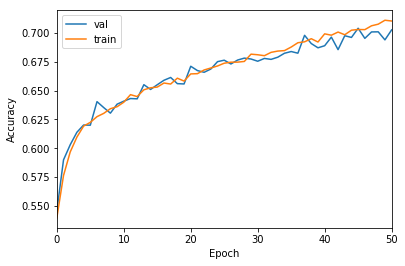

In [17]:
pd.Series(history['val_acc']).plot(label='val')
pd.Series(history['acc']).plot(label='train')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

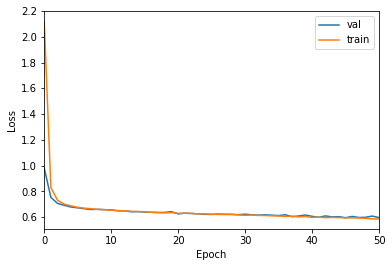

In [18]:
pd.Series(history['val_loss']).plot(label='val')
pd.Series(history['loss']).plot(label='train')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')